In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys
import os
import cv2
import time

from PIL import Image

In [9]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

using device: cpu


In [10]:
# segment-anything-2 functions
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [11]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "/home/wsl/bin/segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [12]:
from skimage.segmentation import clear_border

def generate_border(mask, image, border_size):
    # Erode the mask to shrink it slightly
    erosion_kernel = np.ones((3, 3), np.uint8)      # Kernel for erosion
    eroded_mask = cv2.erode(mask, erosion_kernel, iterations=1)  
 
    # Define the kernel size for dilation based on the desired border size (Add 1 to keep it odd)
    kernel_size = 2*border_size + 1 
    dilation_kernel = np.ones((kernel_size, kernel_size), np.uint8)   # Kernel for dilation
    dilated_mask = cv2.dilate(eroded_mask, dilation_kernel, iterations=1)

    # Replace 255 values to 127 for all pixels in the dilated mask (border pixels)
    dilated_127_mask = np.where(dilated_mask == 255, 127, dilated_mask) 
    
    # In the dilated mask, convert the eroded object parts to pixel value 255
    # What's remaining with a value of 127 would be the boundary pixels.
    mask_with_border = np.where(eroded_mask > 127, 255, dilated_127_mask)

    # Now, apply this border mask to the original image to draw the border
    # First, create a copy of the original image
    image_with_border = image.copy()
    
    # Convert the mask to a binary form where 127 represents border pixels
    border_pixels = mask_with_border == 127
    
    # Apply the border to the original image where border_pixels is True
    image_with_border[border_pixels] = (0, 0, 0)
    
    return image_with_border

def remove_noise(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return image

    largest_contour = max(contours, key=cv2.contourArea)
    cleaned_image = np.zeros_like(image)
    cv2.drawContours(cleaned_image, [largest_contour], -1, 255, thickness=cv2.FILLED)

    return cleaned_image

In [13]:
from skimage.segmentation import clear_border
    
def wing_segmentation(wing):
    gray_crop = cv2.cvtColor(wing, cv2.COLOR_BGR2GRAY)
    # blurred_crop = cv2.medianBlur(gray_crop, 5)
    _, thresh = cv2.threshold(gray_crop, 200, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 50000]
    
    # Sort the contours from left to right (by the x-coordinate of their bounding box)
    sorted_contours = sorted(large_contours, key=lambda cnt: cv2.boundingRect(cnt)[0])
    
    # Draw contours on the image for visualization
    contour_image = wing.copy()
    # cv2.drawContours(wing_contour_image, large_contours, -1, (0, 0, 0), 5)
    cv2.drawContours(contour_image, large_contours, -1, (0, 0, 0), thickness=cv2.FILLED)
    
    mask = np.zeros_like(contour_image[:, :, 0]) 
    # Fill the contour area on the mask
    mask = cv2.drawContours(mask, large_contours, -1, 255, thickness=cv2.FILLED)
    mask_inv = cv2.bitwise_not(mask)
    
    # Define the color you want to fill the outside with (e.g., red)
    fill_color = (255, 255, 255)
    
    # Convert the color to an array with the same shape as the image
    color_layer = np.full_like(contour_image, fill_color)
    
    image_outside_colored = np.where(mask_inv[:, :, None] == 255, color_layer, wing)
    # image_outside_colored = np.where(mask_inv, gray_crop)
    
    # plt.figure(figsize=(5, 5))
    # plt.imshow(cv2.cvtColor(image_outside_colored, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.show()
    
    bordered_wings = generate_border(mask_inv, image_outside_colored, 5)
    
    # plt.figure(figsize=(5, 5))
    # plt.imshow(cv2.cvtColor(bordered_wings, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.show()
    
    bin_threshold = 120
    gray_bordered_wings = cv2.cvtColor(bordered_wings, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_bordered_wings, bin_threshold, 255, cv2.THRESH_BINARY)
    
    # plt.figure(figsize=(5, 5))
    # plt.imshow(cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.show()
    
    # Find contours
    clear_wing = clear_border(binary_image)
    # left_wing = cv2.bitwise_not(left_wing)
    contours, _ = cv2.findContours(clear_wing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]
    contours = large_contours
    
    # Sort the contours from left to right (by the x-coordinate of their bounding box)
    # sorted_contours = sorted(large_contours, key=lambda cnt: cv2.boundingRect(cnt)[0])
    
    # Draw contours on the image for visualization
    wing_contour_image = clear_wing.copy()
    wing_contour_image = cv2.cvtColor(wing_contour_image, cv2.COLOR_GRAY2RGB)
    # cv2.drawContours(left_wing_contour_image, large_contours, -1, (0, 0, 255), 5)
    
    wing_rgb = wing.copy()

    points = []
    # Calculate and display the size of each contour (segment)
    segment_areas = []
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        segment_areas.append(area)
        
        # Draw each contour for visualization
        cv2.drawContours(wing_rgb, [contour], -1, (255, 0, 0), 2)
        # Display area as text on the image
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])  # Centroid x
            cy = int(M['m01'] / M['m00'])  # Centroid y
            cv2.putText(wing_rgb, f'{int(area)}', (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        cv2.circle(wing_rgb, (cx, cy), 7, (255, 0, 0), -1)
        points.append([[cx, cy]])
    
    # Convert the points list to a numpy array
    image_pts = np.array(points)
    image_labels = np.ones((len(image_pts), 1), dtype=int)
    # Display the wing with contours and segment areas
    # plt.figure(figsize=(10, 10))
    # plt.imshow(cv2.cvtColor(wing_rgb, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.show()

    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    ax0.imshow(binary_image, cmap="gray")
    ax0.axis('off')
    ax1.imshow(wing_rgb)
    ax1.axis('off')
    plt.show()
    
    # Print the areas of each segment
    # print("Areas of the wing segments:")
    # for i, area in enumerate(segment_areas):
    #     print(f"Segment {i + 1}: {area} pixels")

    # print(image_pts)
    # print(len(contours))

    img_batch = [wing]
    pts_batch = [image_pts]
    labels_batch = [image_labels]
    predictor.set_image_batch(img_batch)
    masks_batch, scores_batch, _ = predictor.predict_batch(pts_batch, labels_batch, box_batch=None, multimask_output=True)
    
    # Select the best single mask per object
    best_masks = []
    for masks, scores in zip(masks_batch,scores_batch):
        best_masks.append(masks[range(len(masks)), np.argmax(scores, axis=-1)])
    
    for image, points, labels, masks in zip(img_batch, pts_batch, labels_batch, best_masks):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)   
        for mask in masks:
            show_mask(mask, plt.gca(), random_color=True)
        show_points(points, labels, plt.gca())
    
    return image_pts
# wing_segmentation(wing)

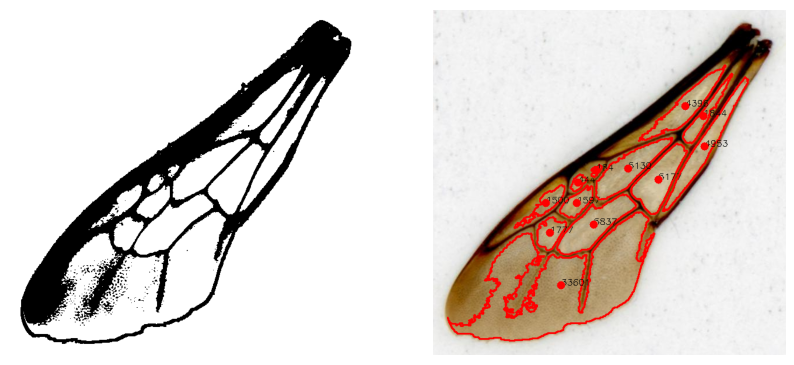

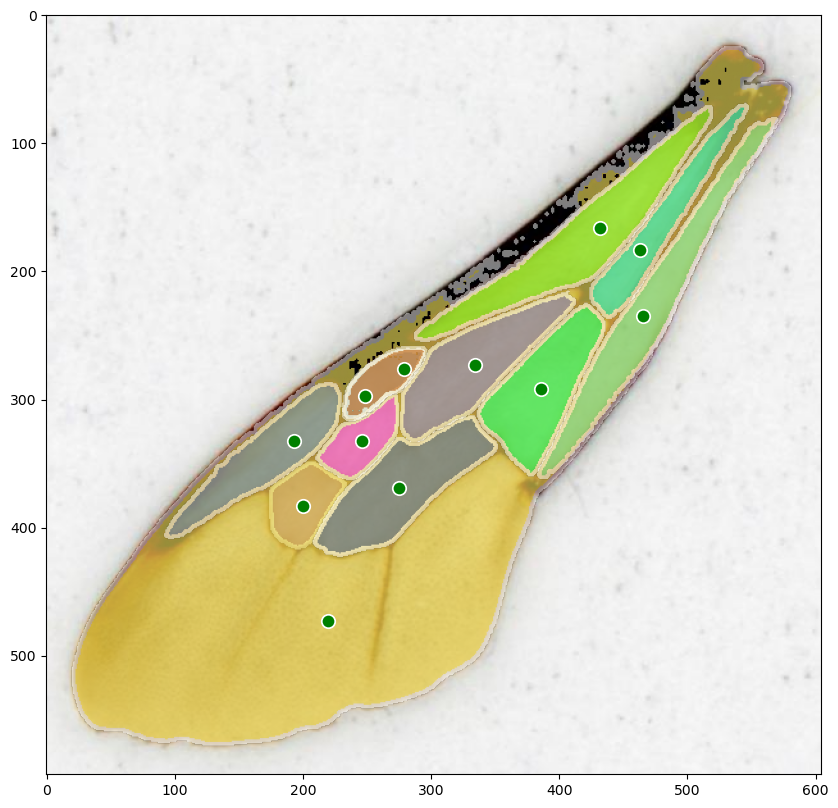

In [14]:
input_dir = "/mnt/c/Projects/Master/Data/WingScanCrops/Hive01_Sheet_01/"
output_dir = "/mnt/c/Projects/Master/Data/Segmented/Hive01_Sheet_01/"

# Ensure the input directory exists
if not os.path.exists(input_dir):
    raise FileNotFoundError(f"Input directory '{input_dir}' was not found.")

# Create the output directory
os.makedirs(output_dir, exist_ok=True)

# Find jpg files
jpg_files = [file for file in os.listdir(input_dir) if file.endswith('.jpg')]

# Loop through all scans
for i, filename in enumerate(jpg_files):
    if filename != "Hive01_Sheet_01_Label_1_Left.jpg":
        continue
    input_file = input_dir + filename
    wing = Image.open(input_file)
    wing = np.array(wing.convert("RGB"))
    image_pts = wing_segmentation(wing)